# Результаты однозадачного обучения IEMOCAP
### Использованные модели:
1. **AlexNet** <font color=green>[Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. <i>Commun. ACM</i> 60, 6 (June 2017), 84–90. DOI:https://doi.org/10.1145/3065386]</font> c немного измененной архитектурой, а именно:
    - Количество входных каналов первого сверточного слоя уменьшено с 3 до 1
    - Изменён последний свёрточный слой, его ядро увеличено с (3, 3) до (4, 4)
    - Изменён слой AdaptiveAvgPool2d с (6, 6) до (5, 5)
    - Изменён классификатор, теперь это четыре полносвязных слоя: 6400, 2048, 512, <число классов>
    - Добавлен Dropout() после первого и второго полносвязного слоя
2. **VGG-11, VGG-19** <font color=green>[Simonyan, Karen & Zisserman, Andrew. (2014). Very Deep Convolutional Networks for Large-Scale Image Recognition. arXiv 1409.1556. ]</font>, также немного переделанные, чтобы соответствовать нашим данным
3. **ResNet-34, ResNet-50** <font color=green>[K. He, X. Zhang, S. Ren and J. Sun, "Deep Residual Learning for Image Recognition," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, 2016, pp. 770-778, doi: 10.1109/CVPR.2016.90.]</font>
4. **DeepNet** <font color=green>[Anvarjon, T.; Mustaqeem; Kwon, S. Deep-Net: A Lightweight CNN-Based Speech Emotion Recognition System Using Deep Frequency Features. Sensors 2020, 20, 5212.]</font><br>У этой архитектуры заявлена точность на четырехклассовом IEMOCAP 77%. Отличается использованием свёртки с ядрами от (11,1) до (1,1), таким образом, свёртка спектрограммы происходит только по частотной оси. На вход подаются спектрограммы размерности 64х64. <br>
5. **StrideNet** <font color=green>[., Mustaqeem & Kwon, Soonil. (2019). A CNN-Assisted Enhanced Audio Signal Processing for Speech Emotion Recognition. Sensors. 20. 183. 10.3390/s20010183. ]</font> <br> Ещё одна архитектура с высокой заявленной точностью.
Особенностью этой архитектуры является отсутствие Pooling слоёв: снижение размерности достигается использованием шага свёртки, равного двум. На вход подаются спектрограммы размером 128x128  <br>

### Датасет
Был использован IEMOCAP с четырьмя эмоциональными категориями (Anger, Happiness, Neutral, Sadness). Были протестированы следующие варианты: <br>
1. Без "аугментации", без препроцессинга
2. Без "аугментации", с препроцессингом
3. С "аугментацией", без препроцессинга
4. С "аугментацией", с препроцессингом

### Процесс обучения.
Все модели были обучены с использованием Adam, learning rate=1e-5, количество эпох - от 300 до 700. Также для ускорения процесса, поскольку вариантов много, в ходе экспериментов в процесс обучения была включена возможность остановить обучение, если validation loss не уменьшался на протяжении определенного количества эпох. Лучшие модели (с наименьшим показателем validation loss) сохранялись на жесткий диск с помощью pickle. 

In [62]:
import pandas as pd 
import pickle
import numpy as np 
import matplotlib.pyplot as plt
import os
from constants import *
from IPython.display import display 
import seaborn as sns 

In [20]:
def create_results_df(net):
    dfs_list = []
    for metric in ['acc', 'loss']:
        _dfs_list = []
        for subset in ['train', 'valid']:
            results = net.history[:, f'{subset}_{metric}']
            df = pd.DataFrame(results, columns=['result'])
            df['epochs'] = np.arange(1, len(results) + 1)
            df['subset'] = subset
            _dfs_list.append(df)
        df = pd.concat(_dfs_list, ignore_index=True)
        df['metric'] = metric
        dfs_list.append(df)
    final_df = pd.concat(dfs_list, ignore_index=True)
    return final_df

In [21]:
def create_results_summary():
    dfs_list = []
    models_list = [file for file in os.listdir(RESULTS_FOLDER) if file.endswith('md') and 'IEMOCAP' in file]
    path_to_processed_list = os.path.join(RESULTS_FOLDER, 'processed_list.temp')
    if os.path.exists(path_to_processed_list):
        with open(path_to_processed_list, 'rb') as f:
            processed_list = pickle.load(f)
            files_list = processed_list['files']
            dfs_list = processed_list['dfs']
    else:
        processed_list = {}
        dfs_list = []
        files_list = []
    for file in models_list:
        print(file)
        if file in files_list:
            continue
        model, dataset = file[:-3].split('--')
        dataset, _, preprocessing, _, _, augmentation = dataset.split('_')
        preprocessing = preprocessing.split('-')[-1]
        augmentation = augmentation.split('-')[-1]
        with open(os.path.join(RESULTS_FOLDER, file), 'rb') as f:
            net = pickle.load(f)
        df = create_results_df(net)
        df['model'] = model
        df['dataset'] = dataset
        df['preprocessing'] = preprocessing
        df['augmentation'] = augmentation
        print(df)
        dfs_list.append(df)
        files_list.append(file)
        processed_list['dfs'] = dfs_list
        processed_list['files'] = files_list
        with open(path_to_processed_list, 'wb') as f:
            pickle.dump(processed_list, f)
        print('///Done///')
    if len(files_list) == len(models_list):
        final_df = pd.concat(dfs_list, ignore_index=True)
        final_df.to_csv(os.path.join(RESULTS_FOLDER, 'iemocap_all_results.csv'), sep = ';', index=False)

In [22]:
create_results_summary()

AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-false.md
AlexNet--IEMOCAP-4_four_prep-false_224_train_augmentation-true.md
AlexNet--IEMOCAP-4_four_prep-true_224_train_augmentation-false.md
AlexNet--IEMOCAP-4_four_prep-true_224_train_augmentation-true.md
DeepNet--IEMOCAP-4_four_prep-false_64_train_augmentation-false.md
DeepNet--IEMOCAP-4_four_prep-false_64_train_augmentation-true.md
DeepNet--IEMOCAP-4_four_prep-true_64_train_augmentation-false.md
DeepNet--IEMOCAP-4_four_prep-true_64_train_augmentation-true.md
ResNet34--IEMOCAP-4_four_prep-false_224_train_augmentation-true.md
ResNet50--IEMOCAP-4_four_prep-false_224_train_augmentation-true.md
StrideNet--IEMOCAP-4_four_prep-false_128_train_augmentation-false.md
StrideNet--IEMOCAP-4_four_prep-true_128_train_augmentation-false.md
VggNet--IEMOCAP-4_four_prep-false_128_train_augmentation-false.md
VggNet--IEMOCAP-4_four_prep-false_224_train_augmentation-true.md
VggNet--IEMOCAP-4_four_prep-true_224_train_augmentation-false.md
VggNet--I

### Результаты всех однозадачных моделей на датасете IEMOCAP содержатся в файле iemocap_all_results.csv

In [29]:
df = pd.read_csv(os.path.join(RESULTS_FOLDER, 'iemocap_all_results.csv'), delimiter=';')
df

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
0,0.513438,1,train,acc,VggNet,IEMOCAP-4,True,False
1,0.587066,2,train,acc,VggNet,IEMOCAP-4,True,False
2,0.594345,3,train,acc,VggNet,IEMOCAP-4,True,False
3,0.609183,4,train,acc,VggNet,IEMOCAP-4,True,False
4,0.611982,5,train,acc,VggNet,IEMOCAP-4,True,False
...,...,...,...,...,...,...,...,...
18043,0.933324,181,valid,loss,DeepNet,IEMOCAP-4,True,False
18044,0.926249,182,valid,loss,DeepNet,IEMOCAP-4,True,False
18045,0.929249,183,valid,loss,DeepNet,IEMOCAP-4,True,False
18046,0.919920,184,valid,loss,DeepNet,IEMOCAP-4,True,False


### Найдем результат лучшей модели (лучшей считается модель с наименьшим значением validation loss)

In [48]:
# Найдем лучший результат
val_losses = df.loc[(df['metric'] == 'loss') & (df['subset'] == 'valid')]
best_results = val_losses.groupby('model').min().sort_values('result')
best_results.drop(best_results.columns.tolist()[1:], axis=1, inplace=True)
best_results

,result
model,
AlexNet,0.791347
VggNet,0.792008
VggNet-19,0.843104
StrideNet,0.854611
ResNet50,0.874697
DeepNet,0.891184
ResNet34,1.017847


In [60]:
for result in best_results.result.tolist():
    _df = df.loc[df['result'] == result]
    display(_df)
    print(_df.model.values)

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
5499,0.791347,21,valid,loss,AlexNet,IEMOCAP-4,False,False


['AlexNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
5256,0.792008,35,valid,loss,VggNet,IEMOCAP-4,False,True


['VggNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
3227,0.843104,19,valid,loss,VggNet-19,IEMOCAP-4,False,True


['VggNet-19']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
9683,0.854611,652,valid,loss,StrideNet,IEMOCAP-4,False,False


['StrideNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
427,0.874697,86,valid,loss,ResNet50,IEMOCAP-4,False,True


['ResNet50']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
10174,0.891184,40,valid,loss,DeepNet,IEMOCAP-4,False,False


['DeepNet']


,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
83,1.017847,2,valid,loss,ResNet34,IEMOCAP-4,False,True


['ResNet34']


### Итак, лучший результат показала AlexNet без препроцессинга и аугментации (зачем вообще стоило стараться?) <br> 
#### Ладно, построим графики обучения этой модели для приличия что ли 

In [65]:
alex_results = df.loc[(df['model'] == 'AlexNet') & (df['preprocessing'] == False) & (df['augmentation'] == False) ]
alex_results.loc[alex_results['epochs'] == 21]

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
5436,0.730683,21,train,acc,AlexNet,IEMOCAP-4,False,False
5457,0.686450,21,valid,acc,AlexNet,IEMOCAP-4,False,False
5478,0.679132,21,train,loss,AlexNet,IEMOCAP-4,False,False
5499,0.791347,21,valid,loss,AlexNet,IEMOCAP-4,False,False


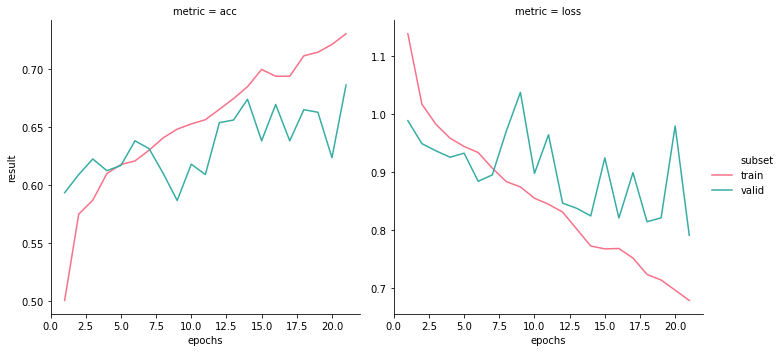

In [64]:
sns.relplot(x='epochs', y='result', hue='subset', size=None, style=None, 
            data=alex_results, col='metric', palette='husl',
            kind='line', height=5, aspect=1, markers=True,
            facet_kws={
                'sharey': False
            })

### На втором месте с практически идентичным validation loss - Vgg-11 с батч-нормализацией, без препроцессинга и с аугментацией. 
#### Взглянем на эту модель тоже.

In [66]:
vgg_results = df.loc[(df['model'] == 'VggNet') & (df['preprocessing'] == False) & (df['augmentation'] == True)]
vgg_results.loc[vgg_results['epochs'] == 35]

,result,epochs,subset,metric,model,dataset,preprocessing,augmentation
4674,0.733763,35,train,acc,VggNet,IEMOCAP-4,False,True
4868,0.683091,35,valid,acc,VggNet,IEMOCAP-4,False,True
5062,0.686269,35,train,loss,VggNet,IEMOCAP-4,False,True
5256,0.792008,35,valid,loss,VggNet,IEMOCAP-4,False,True


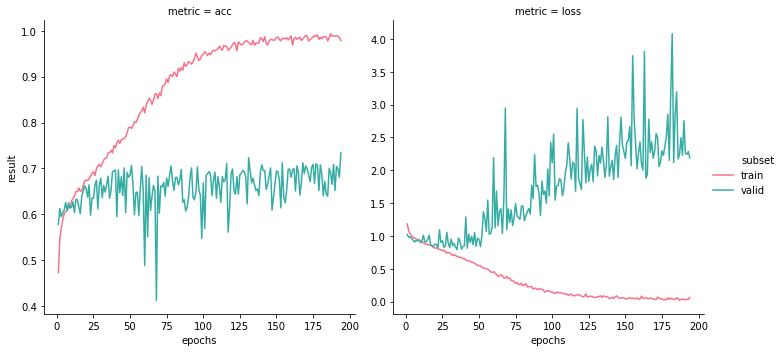

In [67]:
sns.relplot(x='epochs', y='result', hue='subset', size=None, style=None, 
            data=vgg_results, col='metric', palette='husl',
            kind='line', height=5, aspect=1, markers=True,
            facet_kws={
                'sharey': False
            })

# Выводы.

Препроцессинг себя показал абсолютно никак, видно, что модели лучше справляются без него. Эффективность аугментации так же под вопросом.<br>
Наилучшие показатели в однозадачном обучении - у AlexNet и VggNet-11 c батч-нормализацией. <br>
Повторить результаты моделей DeepNet и StrideNet, описанные в соответствующих статьях - не удалось.